# Get feature importance / SHAP values

In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as pl
import ml_help
from time import time
import seaborn as sns
sns.set_theme()

/home/uncle_opal/miniconda3/envs/rapids/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/uncle_opal/miniconda3/envs/rapids/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def d

In [10]:
df = pd.read_csv("./data/yonge_flow.csv.zip")
df["collectedAt"] = pd.to_datetime(df["collectedAt"], utc=True)
df.drop(["month","day_of_week"], axis=1, inplace=True)
df["Day"] = df["day"]
df["Hour"] = df["hour"]
df["Minute"] = df["minute"]
df["Month"] = df.collectedAt.dt.month_name()
df["Weekday"] = df.collectedAt.dt.day_name()
df.drop(["collectedAt", "day", "hour", "minute"],axis=1,inplace=True)
df

,currentSpeed,Day,Hour,Minute,Month,Weekday
0,10,14,12,45,July,Thursday
1,13,14,12,51,July,Thursday
2,18,14,12,55,July,Thursday
3,13,14,13,0,July,Thursday
4,14,14,13,5,July,Thursday
...,...,...,...,...,...,...
73530,10,26,21,35,March,Sunday
73531,13,26,21,40,March,Sunday
73532,18,26,21,45,March,Sunday
73533,13,26,21,50,March,Sunday


In [11]:
categorical_feats = ["Month","Weekday"]

transformed_df = pd.get_dummies(df, columns=categorical_feats, prefix="", prefix_sep="")
transformed_df = transformed_df.astype("float32")
transformed_df

,currentSpeed,Day,Hour,Minute,August,December,February,January,July,March,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,10.0,14.0,12.0,45.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,13.0,14.0,12.0,51.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,18.0,14.0,12.0,55.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,13.0,14.0,13.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,14.0,14.0,13.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73530,10.0,26.0,21.0,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
73531,13.0,26.0,21.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
73532,18.0,26.0,21.0,45.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
73533,13.0,26.0,21.0,50.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
X = transformed_df.drop("currentSpeed",axis=1)
y = transformed_df["currentSpeed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.80 = 0.20

# XGBoost

Fitting...
Fitting... OK! Took 3.4373412132263184 seconds
Explaining...
Explaining... OK! Took 0.9546926021575928 seconds
Calculating shap values...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Calculating shap values... OK! Took 8.026777744293213 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


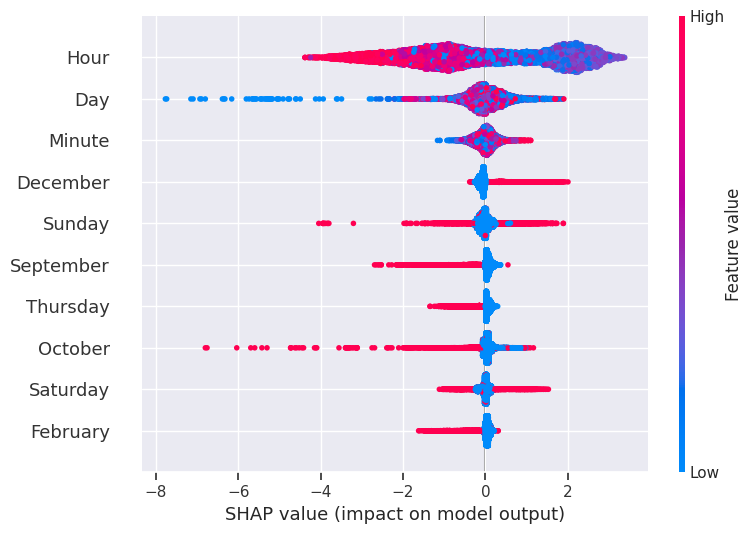

In [13]:
import xgboost as xgb

params = ml_help.params_to_dict("023_xgboost")
params['predictor'] = 'cpu_predictor'
params['tree_method'] = 'hist'
model = xgb.XGBRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
xgboost_fig = pl.gcf()
pl.savefig("./plots/026_xgboost.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/026_xgboost.png", bbox_inches="tight")
pl.savefig("./plots/026_xgboost.pdf", bbox_inches="tight")

# Random Forest

Fitting...
Fitting... OK! Took 3.7362968921661377 seconds
Explaining...
Explaining... OK! Took 0.005821943283081055 seconds
Calculating shap values...
Calculating shap values... OK! Took 28.086775064468384 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


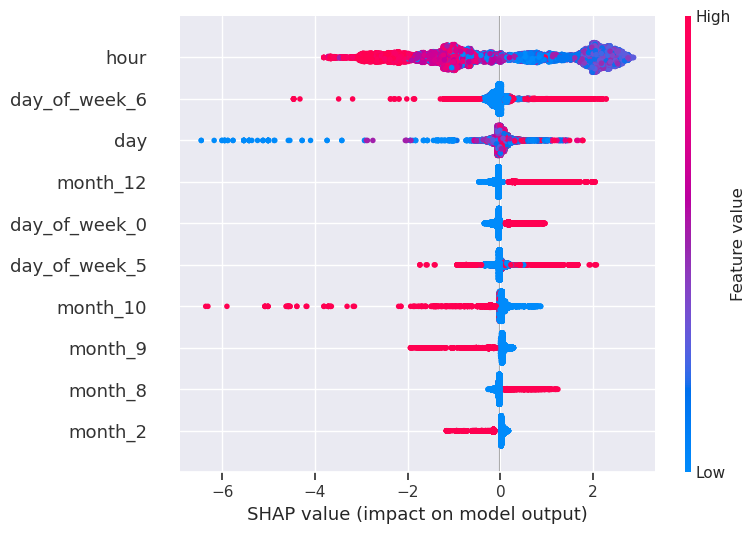

In [6]:
from sklearn.ensemble import RandomForestRegressor

params = ml_help.params_to_dict("023_random_forest")
model = RandomForestRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/026_random_forest.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/026_random_forest.png", bbox_inches="tight")

# Decision Tree

Fitting...
Fitting... OK! Took 0.0537264347076416 seconds
Explaining...
Explaining... OK! Took 0.0005564689636230469 seconds
Calculating shap values...
Calculating shap values... OK! Took 0.2941899299621582 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


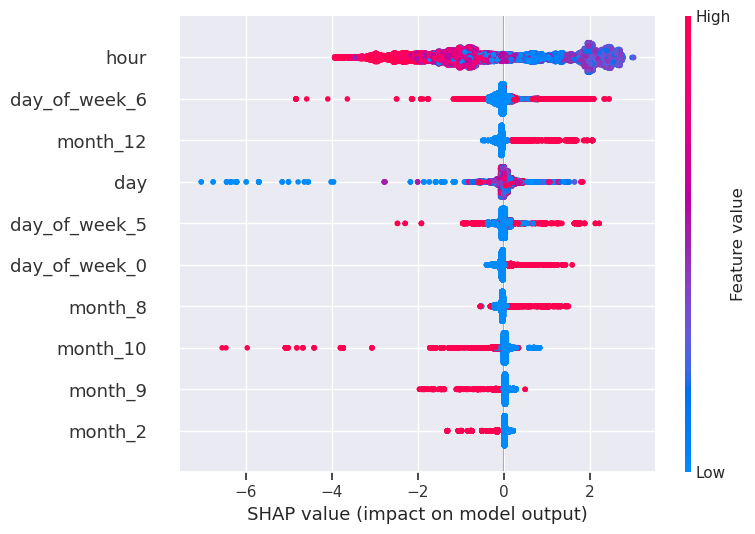

In [7]:
from sklearn.tree import DecisionTreeRegressor

params = ml_help.params_to_dict("023_decision_tree")
model = DecisionTreeRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/026_decision_tree.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/026_decision_tree.png", bbox_inches="tight")

# MLP

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Fitting...
Fitting... OK! Took 85.54152131080627 seconds
Explaining...
Explaining... OK! Took 0.0005557537078857422 seconds
Calculating shap values...


X does not have valid feature names, but MLPRegressor was fitted with feature names


  0%|          | 0/14707 [00:00<?, ?it/s]

Calculating shap values... OK! Took 180.5331790447235 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


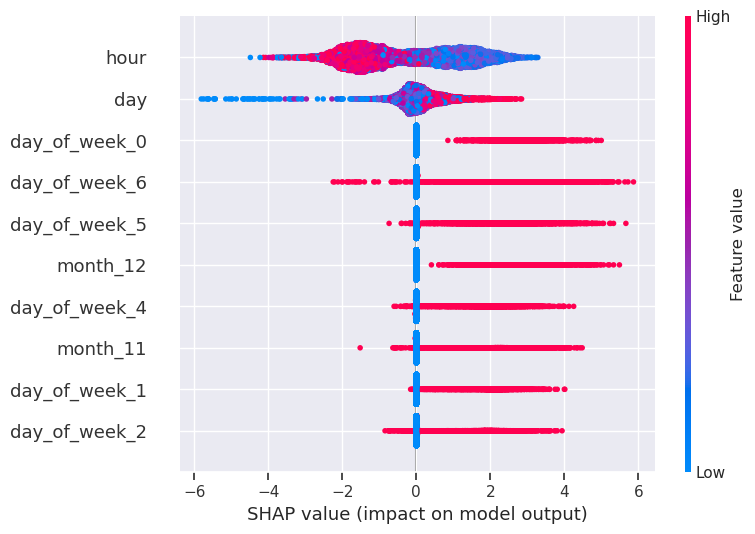

In [8]:
from sklearn.neural_network import MLPRegressor
import warnings

X_train_summary = shap.kmeans(X_train, 10)

params = ml_help.params_to_dict("023_mlpr")
model = MLPRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.KernelExplainer(model.predict, X_train_summary)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/026_mlp.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/026_mlp.png", bbox_inches="tight")